In [1]:
import numpy as np
from tqdm import tqdm
import random
from scipy.special import expit
import os
from scipy import stats
import networkx as nx

Características de los sujetos: *menor de edad*

Características de los delitos: *violencia*

Tipos de crímen: *encerrona, asalto*

Sobre los betas, propensión de cada sujeto a cometer crímenes
Menor de edad tiene mayor prob. de cometer delitos con violencia.

$P(X) = ???$

$P(x_i = 1 | x_{-i}) = logit^{-1}(\gamma w_i + \beta_i z + \sum_{j}{x_j (\theta_j w_i +\theta_i w_j)}) * logit^{-1}(\sum_{j}{x_j \lambda d_{i,j}})$

In [31]:
betas_mayores = stats.norm(loc=-2, scale=0.5).rvs(size = 5)
betas_menores = stats.norm(loc=2, scale=0.5).rvs(size = 5)

thetas_mayores = stats.norm(loc=0, scale=0.5).rvs(size = 5)
thetas_menores = stats.norm(loc=-2, scale=0.5).rvs(size = 5)
sujetos = {1:{"menor":1},2:{"menor":1},
           3:{"menor":1},4:{"menor":1},
           5:{"menor":1},6:{"menor":0},
           7:{"menor":0},8:{"menor":0},
           9:{"menor":0},10:{"menor":0}}

gamma = 0.5
betas = np.concat([betas_menores, betas_mayores])
thetas = np.concat([thetas_menores, thetas_mayores])
lambd = -0.2

In [32]:
G = nx.Graph()
G.add_edges_from([(1,2),(1,3), (2,3), (1,4), (3,5), (3,7), (7,10), (7,9), (7,8), (8,6)])
D = nx.floyd_warshall_numpy(G)
D[0]

array([0., 1., 1., 1., 2., 2., 3., 3., 3., 4.])

In [38]:
delitos = [1]*40 + [0]*40

delitos_grupos = []
for z_j in tqdm(delitos):

   # Definimos el grupo inicial
   group = []
   for s in sujetos:
      if random.random() > 0.5:
         group.append(1)
      else:
         group.append(0)   
   group = np.array(group)

   N_iter = 20000

   samples = []

   i_index = list(sujetos.keys())
   I = len(sujetos)

   for n in range(N_iter):

      i_order = random.sample(i_index, I)

      for s in i_order:

         v = np.dot(D[s-1], group)*lambd
         p0 = expit(v)
         if not(random.random() < p0):
            group[s-1] = 0
         
         else:
            w_i = np.array(list(sujetos[s].values()))

            node_propension = np.dot(w_i, gamma)
            link_preference = np.dot(z_j, betas[s-1])
            F_j = thetas*w_i + thetas[s-1] * np.array([i["menor"] for i in sujetos.values()])
            F_j[s-1] = 0
            q = F_j * group
            group_preference = np.dot(q,np.ones(len(q)))
            util = node_propension + link_preference + group_preference
            p = expit(util)
            
            if (random.random() <= p):
               group[s-1] = 1
            else:
               group[s-1] = 0

      # Terminamos la iteración por los sujetos de la red
      if (n > 1000) & (n%10 == 0):
         samples.append(group.copy())
   delitos_grupos.append(random.sample(samples, 1)[0].copy().tolist())
      

100%|██████████| 80/80 [01:36<00:00,  1.21s/it]


<Axes: ylabel='Count'>

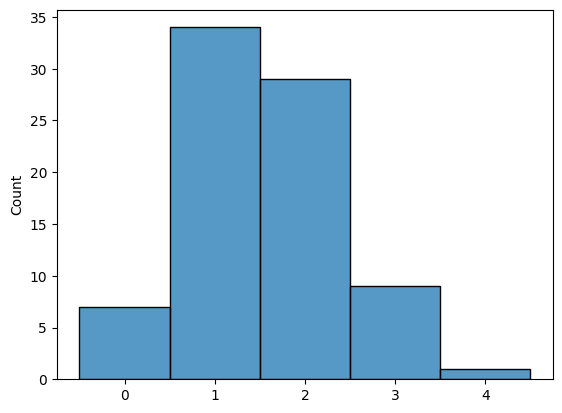

In [35]:
import seaborn as sns
tamaño_grupos = []
for g in delitos_grupos:
    tamaño_grupos.append(sum(g))
sns.histplot(tamaño_grupos, discrete=True)

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# --- Pairwise pseudolikelihood ---
def neg_log_pairwise_pl(params, delitos_grupos, delitos, sujetos, D, alpha=1e-2):
    T = len(delitos_grupos)
    n = len(delitos_grupos[0])
    
    gamma = params[0]
    lmbda = params[1]
    beta = params[2:2+n]
    theta = params[2+n:2+2*n]
    
    # atributo binario "menor"
    w = np.array([sujetos[i+1]["menor"] for i in range(n)])
    
    loglik = 0.0
    for t in range(T):
        x = np.array(delitos_grupos[t])
        z = delitos[t]
        
        # recorrer todos los pares (i,j)
        for i in range(n):
            for j in range(i+1, n):
                # --- energía "local" del par (i,j) ---
                A_i = gamma*w[i] + beta[i]*z
                A_j = gamma*w[j] + beta[j]*z
                
                # contribuciones de interacciones
                sum_i = sum(theta[k]*w[i] + theta[i]*w[k] for k in range(n) if k != i and x[k]==1 and k!=j)
                sum_j = sum(theta[k]*w[j] + theta[j]*w[k] for k in range(n) if k != j and x[k]==1 and k!=i)
                
                A_i += sum_i
                A_j += sum_j
                
                B_i = lmbda * np.sum([x[k]*D[i,k] for k in range(n) if k not in (i,j)])
                B_j = lmbda * np.sum([x[k]*D[j,k] for k in range(n) if k not in (i,j)])
                
                # prob condicional marginal de (x_i, x_j) dado resto
                # se normaliza con las 4 configuraciones posibles
                energies = []
                probs = []
                for xi in [0,1]:
                    for xj in [0,1]:
                        e_i = xi*(A_i) + xi*np.log(sigmoid(B_i))
                        e_j = xj*(A_j) + xj*np.log(sigmoid(B_j))
                        # interacción entre i y j si ambos están activos
                        e_pair = 0.0
                        if xi==1 and xj==1:
                            e_pair += theta[j]*w[i] + theta[i]*w[j] + lmbda*D[i,j]
                        energies.append(e_i + e_j + e_pair)
                
                # softmax para normalizar
                max_e = np.max(energies)
                exp_e = np.exp(np.array(energies)-max_e)
                probs = exp_e/np.sum(exp_e)
                
                # índice observado
                idx_obs = 2*x[i] + x[j]
                p_obs = probs[idx_obs]
                p_obs = np.clip(p_obs, 1e-9, 1-1e-9)
                
                loglik += np.log(p_obs)
    
    penalty = alpha*(gamma**2 + lmbda**2 + np.sum(beta**2) + np.sum(theta**2))
    return -(loglik - penalty)


def fit_pairwise_pl(delitos_grupos, delitos, sujetos, D, alpha=1e-2):
    n = len(delitos_grupos[0])
    init = np.zeros(2 + 2*n)  
    
    result = minimize(
        neg_log_pairwise_pl,
        init,
        args=(delitos_grupos, delitos, sujetos, D, alpha),
        method="BFGS"
    )
    
    params = result.x
    gamma = params[0]
    lmbda = params[1]
    beta  = params[2:2+n]
    theta = params[2+n:2+2*n]
    
    # matriz de covarianza aprox
    if hasattr(result, "hess_inv"):
        cov_matrix = result.hess_inv
        if not isinstance(cov_matrix, np.ndarray):
            cov_matrix = cov_matrix.todense()
        cov_matrix = np.array(cov_matrix)
        se = np.sqrt(np.diag(cov_matrix))
    else:
        cov_matrix = None
        se = np.full_like(params, np.nan)
    
    z_vals = params / se
    p_vals = 2 * (1 - norm.cdf(np.abs(z_vals)))
    
    summary = {
        "params": params,
        "stderr": se,
        "z": z_vals,
        "pval": p_vals,
        "success": result.success,
        "loglik": -result.fun
    }
    
    return summary


# --- Ejemplo de uso ---
res = fit_pairwise_pl(delitos_grupos, delitos, sujetos, D, alpha=1)

print("Log-pairwise PL:", res["loglik"])
print("Éxito optimización:", res["success"])

names = ["gamma", "lambda"] + \
        [f"beta_{i+1}" for i in range(len(sujetos))] + \
        [f"theta_{i+1}" for i in range(len(sujetos))]

print(f"{'param':10s} {'est':>10s} {'se':>10s} {'z':>10s} {'pval':>10s}")
for name, est, se, z, p in zip(names, res["params"], res["stderr"], res["z"], res["pval"]):
    print(f"{name:10s} {est:10.4f} {se:10.4f} {z:10.3f} {p:10.3f}")


Log-pairwise PL: -3193.9810656914715
Éxito optimización: False
param             est         se          z       pval
gamma          1.1693     0.1169     10.006      0.000
lambda        -0.1005     0.0204     -4.924      0.000
beta_1         1.1799     0.2007      5.880      0.000
beta_2         1.6348     0.1778      9.196      0.000
beta_3         0.8384     0.1808      4.637      0.000
beta_4         1.6701     0.2127      7.853      0.000
beta_5         2.0376     0.1839     11.078      0.000
beta_6        -1.7796     0.1741    -10.219      0.000
beta_7        -0.7238     0.1488     -4.864      0.000
beta_8        -0.9467     0.1458     -6.492      0.000
beta_9        -1.1665     0.1537     -7.588      0.000
beta_10       -1.1231     0.1581     -7.104      0.000
theta_1       -1.5689     0.1039    -15.095      0.000
theta_2       -2.0513     0.1158    -17.709      0.000
theta_3       -1.8262     0.1058    -17.256      0.000
theta_4       -2.4607     0.1274    -19.319      0.000
th

In [8]:
print(gamma)
print(betas)
print(thetas)
print(lambd)

0.5
[ 1.65014742  2.21870828  2.01910163  1.82983195  1.60831097 -2.91378977
 -1.90579193 -2.73240756 -1.57148465 -2.18041556]
[-2.58550656 -2.51363049 -2.18900236 -1.19922359 -1.89883431  0.74037866
  0.2458423   0.72340695 -0.32803859  0.42121017]
-1


In [41]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def neg_log_pseudolik(params, delitos_grupos, delitos, sujetos, D, alpha=1e-2):
    T = len(delitos_grupos)
    n = len(delitos_grupos[0])
    
    gamma = params[0]
    lmbda = params[1]
    beta = params[2:2+n]
    theta = params[2+n:2+2*n]
    
    w = np.array([sujetos[i+1]["menor"] for i in range(n)])
    
    loglik = 0.0
    for t in range(T):
        x = np.array(delitos_grupos[t])
        z = delitos[t]
        for i in range(n):
            A_i = gamma*w[i] + beta[i]*z
            for j in range(n):
                if j == i: continue
                if x[j] == 1:
                    A_i += theta[j]*w[i] + theta[i]*w[j]
            B_i = lmbda * np.sum([x[j]*D[i,j] for j in range(n) if j != i])
            p_i = sigmoid(A_i) * sigmoid(B_i)
            p_i = np.clip(p_i, 1e-9, 1-1e-9)
            if x[i] == 1:
                loglik += np.log(p_i)
            else:
                loglik += np.log(1 - p_i)
    
    penalty = alpha*(gamma**2 + lmbda**2 + np.sum(beta**2) + np.sum(theta**2))
    return -(loglik - penalty)

def fit_pseudolik(delitos_grupos, delitos, sujetos, D, alpha=1e-2):
    n = len(delitos_grupos[0])
    init = np.zeros(2 + 2*n)  
    
    result = minimize(
        neg_log_pseudolik,
        init,
        args=(delitos_grupos, delitos, sujetos, D, alpha),
        method="BFGS"  # BFGS entrega hess_inv aproximado
    )
    
    # parámetros estimados
    params = result.x
    gamma = params[0]
    lmbda = params[1]
    beta  = params[2:2+n]
    theta = params[2+n:2+2*n]
    
    # matriz de covarianza aproximada
    if hasattr(result, "hess_inv"):
        cov_matrix = result.hess_inv
        if not isinstance(cov_matrix, np.ndarray):
            cov_matrix = cov_matrix.todense()  # a veces es objeto especial
        cov_matrix = np.array(cov_matrix)
        se = np.sqrt(np.diag(cov_matrix))
    else:
        cov_matrix = None
        se = np.full_like(params, np.nan)
    
    # estadísticos z y p-values
    z_vals = params / se
    p_vals = 2 * (1 - norm.cdf(np.abs(z_vals)))
    
    summary = {
        
        "params": params,
        "stderr": se,
        "z": z_vals,
        "pval": p_vals,
        "success": result.success,
        "loglik": -result.fun
    }
    
    return summary

res = fit_pseudolik(delitos_grupos, delitos, sujetos, D, alpha=1)

print("Log-pseudoverosimilitud:", res["loglik"])
print("Éxito optimización:", res["success"])

names = ["gamma", "lambda"] + \
        [f"beta_{i+1}" for i in range(len(sujetos))] + \
        [f"theta_{i+1}" for i in range(len(sujetos))]

print(f"{'param':10s} {'est':>10s} {'se':>10s} {'z':>10s} {'pval':>10s}")
for name, est, se, z, p in zip(names, res["params"], res["stderr"], res["z"], res["pval"]):
    print(f"{name:10s} {est:10.4f} {se:10.4f} {z:10.3f} {p:10.3f}")

Log-pseudoverosimilitud: -294.72779554634684
Éxito optimización: False
param             est         se          z       pval
gamma          0.4007     0.0911      4.399      0.000
lambda        -0.1791     0.0549     -3.264      0.001
beta_1         0.3548     0.3555      0.998      0.318
beta_2         0.2697     0.4614      0.584      0.559
beta_3         0.0093     0.4887      0.019      0.985
beta_4         0.4658     0.3403      1.369      0.171
beta_5         0.4718     0.4363      1.082      0.279
beta_6        -0.7182     0.2411     -2.979      0.003
beta_7        -0.5614     0.4091     -1.372      0.170
beta_8        -1.1872     0.4430     -2.680      0.007
beta_9        -0.8461     0.3186     -2.655      0.008
beta_10       -0.9377     0.7164     -1.309      0.191
theta_1       -0.5984     0.2070     -2.890      0.004
theta_2       -1.0316     0.2892     -3.567      0.000
theta_3       -0.3634     0.2323     -1.564      0.118
theta_4       -1.1734     0.3078     -3.812      

In [42]:
print(gamma)
print(betas)
print(thetas)
print(lambd)

0.5
[ 2.2732875   2.18813996  1.82264455  1.61491527  2.3613128  -2.15744251
 -1.4599462  -2.66539337 -2.11445031 -2.03120708]
[-1.60480963 -1.8935356  -3.01584217 -2.18900318 -2.19910225  0.19468203
  0.21152438  0.31831822 -0.92058234  0.02255614]
-0.2


In [53]:
import cmdstanpy
#cmdstanpy.install_cmdstan(compiler=True)

In [62]:
y = delitos_grupos                              # Vectores de incidencia
w = [i["menor"] for i in sujetos.values()]      # Vector de atributos de los nodos
N = len(w)                                      # Cantidad de nodos
z = delitos                                     # Atributos de los delitos
M = len(z)                                      # Cantidad de delitos
cmdstanpy.write_stan_json("stan_models/data_rmf-pseudo2.json", {"y":y, "N":N, "w":w, "M":M, "z":z})

In [63]:
stan_model = cmdstanpy.CmdStanModel(stan_file=os.path.join("stan_models",'rmf-pseudo2.stan'), #force_compile=True
                                    )

fit = stan_model.sample(
    data="stan_models/data_rmf-pseudo2.json",
    chains=4,
    iter_sampling=3000,
    iter_warmup=1000, 
    seed=12345, #show_console=True
)

13:31:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:56:30 - cmdstanpy - INFO - CmdStan done processing.


In [64]:
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



In [65]:
print(gamma)
print(betas)
print(thetas)

0.5
[ 1.9790032   1.56451169  1.62505287  2.45819175  1.82239356  2.89037453
  1.94413883  1.95109822  2.23734227  2.1013476  -2.59500402 -1.27249093
 -1.55601921 -0.76830044 -2.31972328 -1.98958986 -2.5481449  -2.25184774
 -2.51687991 -2.25428651]
[-1.56908682 -1.98969654 -2.49579056 -1.96313735 -2.00847315 -2.02781485
 -2.26733195 -2.56394653 -1.74931132 -2.60366369  0.22739932 -0.07286632
 -0.39034927  0.36903472 -0.07686048 -0.17008079 -0.16052063 -0.40170201
 -0.47157316  0.29293865]


In [66]:
import pandas as pd
pd.set_option('display.max_rows', 500)
display(fit.summary())

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-517.224000,0.070765,4.712570,4.558990,-525.570000,-516.907000,-510.072000,4476.52,7495.01,1.000270
gamma,24.165600,0.020912,1.891890,1.898620,21.088200,24.142400,27.276100,8225.42,7937.26,1.000250
beta[1],2.780150,0.007671,0.705742,0.695124,1.673510,2.747130,3.972880,8613.07,7951.30,1.000070
beta[2],1.483410,0.008610,0.857186,0.837832,0.081698,1.467650,2.900480,9980.79,9133.17,1.000490
beta[3],-0.149192,0.012086,1.239260,1.200050,-2.281270,-0.082253,1.731240,10996.40,8571.34,1.000040
beta[4],2.197790,0.007502,0.779766,0.767764,0.949722,2.172760,3.516160,10971.90,9065.34,1.000220
beta[5],2.140190,0.007942,0.776438,0.764288,0.909989,2.116540,3.470540,9830.11,8077.91,1.000450
beta[6],2.664000,0.007921,0.750828,0.738646,1.457340,2.642500,3.937860,9175.87,8177.87,1.000130
beta[7],0.546117,0.010060,1.064110,1.040750,-1.249550,0.569635,2.241000,11280.70,8973.43,1.000200
beta[8],1.855520,0.008506,0.861256,0.858322,0.448174,1.843150,3.285000,10300.80,9217.55,1.000270


<Axes: ylabel='Count'>

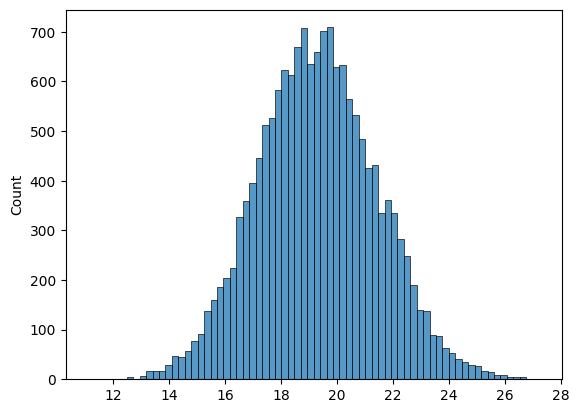

In [49]:
import seaborn as sns
sns.histplot(fit.gamma)